 <img src="http://i.imgur.com/E8JCPrr.jpg" alt="Taj" border="0"/> 
 
 
 



<font color="red">
<h1>What is this project about ?</h1>
</font>



<html>
<body>

<h3>
İt uses USA pollution data from 2000 to 2016, to build an ARIMA (Autoregressive integrated moving average)
model that can be utilized to forecast future pollution Rates 
for specific pollution source in a given area by using some of the 
data for training.
</h3>
<h3>
Goal :  Forecast a time series with ARIMA in Python
</h3>


</body>
</html> 

<font color="red">
<h1>
Getting the data
</h1>
</font>
<h3>


1.	Go <a href="https://www.kaggle.com/sogun3/uspollution" target="_self">Here</a>

</h3>
<h3>
2.	Download the file named “pollution_us_2000_2016.csv” 
</h3>


 <h1> 1. Loading libraries</h1>
 
 
 
<h3>Run the following code to install the libraries that you need when you begin with the forecasting.</h3>
 

In [27]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

 <h1> 2.Loading the data </h1>
 
   <h4>  1. Load the pollution_us_2000_2016.csv file into your notebook by clicking the Find and Add Data icon on the notebook action bar.
     </h4>
     <h4>
         2. Drop the file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project.
 </h4>
 <h4>  Note: we inserted the file as a panda DataFrame. </h4>

In [15]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_a38716b0821f4e289df13c4bd42fbc72(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_f3b512b2996d1751f50c409e1989a2b8de523388','domain': {'id': '59a7fe6a493644679d7cca0fd27366c7'},
            'password': 'MOs1#5^e}//6J-W}'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

pollution_data = pd.read_csv(get_object_storage_file_with_credentials_a38716b0821f4e289df13c4bd42fbc72('finalproject', 'pollution_us_2000_2016.csv'))
pollution_data.head()



,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13,Parts per million,0.878947,2.2,23,25
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4,Parts per million,0.850000,1.6,23,NaN


<h3>Here we partition our data to take State, Date and AQI for NO2, O3 and CO. </h3>

In [16]:
AQI_data = pollution_data[[5,8,13,18,23,28]]
AQI_data.head()

,State,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
0,Arizona,2000-01-01,46,34,13,NaN
1,Arizona,2000-01-01,46,34,13,25
2,Arizona,2000-01-01,46,34,NaN,NaN
3,Arizona,2000-01-01,46,34,NaN,25
4,Arizona,2000-01-02,34,27,4,NaN



<h3>We run the following to convert the DataFrame into a time series with daily frequency: </h3>
<h4> Note : we took only Date and NO2 AQI columns to work on. </h4>

In [17]:
AQI_data.is_copy = False # to be able to modify the copy of the first df
AQI_data['Date Local'] = pd.to_datetime(AQI_data['Date Local'])
indexed_data = AQI_data.set_index('Date Local')

In [18]:
timeseries = indexed_data['NO2 AQI']
timeseries.head()

Date Local
2000-01-01    46
2000-01-01    46
2000-01-01    46
2000-01-01    46
2000-01-02    34
Name: NO2 AQI, dtype: int64

<h1>3. Visualizing the raw data</h1>
<h4>Visualizing data  4 times a day</h4>

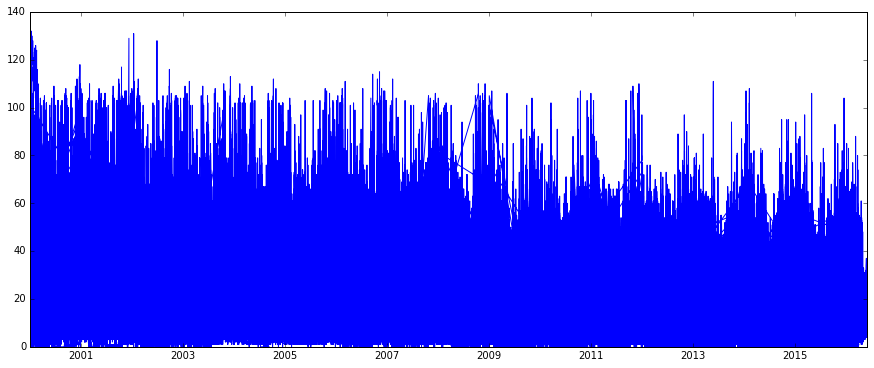

In [28]:
plt.plot(timeseries)  # data for 4 times in a day

<h3>Resample the data</h3> 
<h4>Visualizing data once every week <h/4>

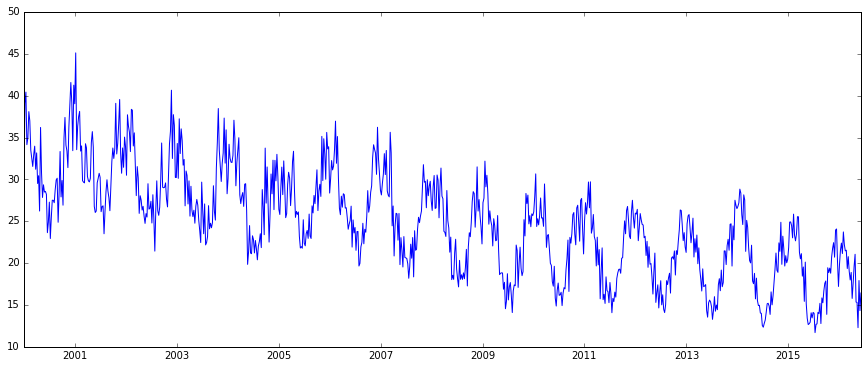

In [31]:
timeseries_week = timeseries.resample('W')  # data for each week
plt.plot(timeseries_week)

<h1>3. Checking for stationarity</h1>

<h3>   
We apply the Dickey-Fuller test on the time series to Checking for stationarity
</h3>

In [21]:
def check_stationarity(timeseries):
    #Perform Dickey-Fuller test: to check if the data id stationary so that we can model an ARIMA model
    print 'Results of the test for stationary:'
    test = adfuller(timeseries, autolag='AIC')  # checking if the timeseries is stationary
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','No. Lags Used','Number of Observations'])
    print "Critical Value: 1%        ",test[4]['1%']
    print result

In [22]:
check_stationarity(timeseries_week)

Results of the test for stationary:
Critical Value: 1%         -3.43810325365
Test Statistic             -4.865703
p-value                     0.000041
No. Lags Used              11.000000
Number of Observations    846.000000
dtype: float64


 <h3>
if the test statistic is more than the 1% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary.
</h3><h4>Note : 
Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series if the condition above isnt satisfied.
</h4>

 <h1>4. Apply a nonlinear log transformation</h1>
 
 
 <h4> Begin by applying a simple, nonlinear log transformation and checking for stationarity : </h4>

In [23]:
timeseries_week_log = np.log(timeseries_week)
check_stationarity(timeseries_week_log)         

Results of the test for stationary:
Critical Value: 1%         -3.43810325365
Test Statistic             -5.316051
p-value                     0.000005
No. Lags Used              11.000000
Number of Observations    846.000000
dtype: float64


<h1>5. Perform and visualize time series forecasting with autoregressive integrated moving average</h1>
<h4> Now we need to split the data set into a training and testing data sets. we will use the training data set to train the ARIMA model and perform out-of-sample forecasting. Then we will compare the results of our out-of-sample predictions for pollution with the actual values from the test data set. </h4>

<h4> Note : For ARIMA we need to have three parameters (p,d,q)<hr>
 We choosed ARIMA(0,1,0), because if the series is not stationary, the simplest possible model for it is a random walk model, which can be considered as a limiting case of an AR(1) model in which the autoregressive coefficient is equal to 1
    
</h4>

In [24]:
cut = int(len(timeseries_week_log) - 15)
train, test = timeseries_week_log[0:cut], timeseries_week_log[cut:len(timeseries_week_log)]
train1 = [x for x in train]
predictions = list()


print('Predicted Values and the Real Values\n')
for i in range(len(test)):
    model = ARIMA(train1, order=(0,1,0))  # model with the train data
    fitting = model.fit(disp=0)  # fit the model
    output = fitting.forecast() # get the output of the forcast
    prediction = output[0] 
    predictions.append(float(prediction)) 
    real_value = test[i]  # get the real value 
    train1.append(real_value)
    
    print('predicted=%f, expected=%f' % (np.exp(prediction), np.exp(real_value)))
    

error = mean_squared_error(test, predictions)
 
print('\nMean Squared Error of Predictions: %.8f' % error)


Predicted Values and the Real Values

predicted=21.529785, expected=19.351716
predicted=19.341824, expected=20.769821
predicted=20.760956, expected=18.998682
predicted=18.988580, expected=17.984106
predicted=17.973388, expected=18.886010
predicted=18.875859, expected=15.780328
predicted=15.768515, expected=17.590164
predicted=17.579260, expected=19.622340
predicted=19.612713, expected=21.052910
predicted=21.044333, expected=15.341463
predicted=15.329525, expected=15.306122
predicted=15.294184, expected=12.285714
predicted=12.272984, expected=17.918367
predicted=17.907725, expected=14.326531
predicted=14.314290, expected=16.428571

Mean Squared Error of Predictions: 0.03004788


In [30]:
from pyspark.sql import Row
raw_data = {'Number of prediction':[i for i in range(15)],
        'predictions': predictions,
        'real': test}
df1 = DataFrame(raw_data, columns = ['Number of prediction','predictions','real'])



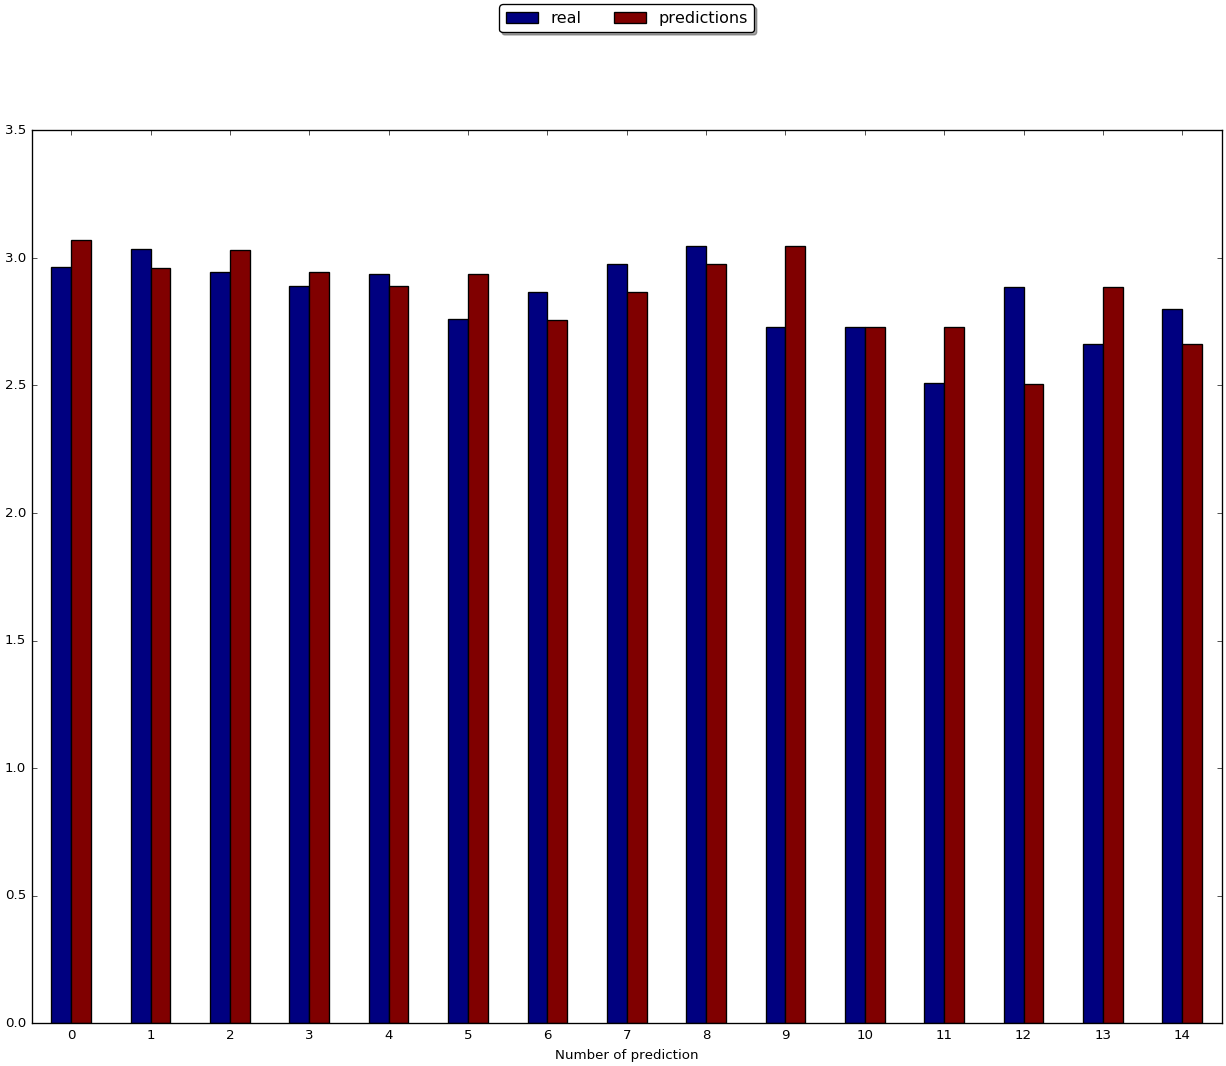

In [26]:
import pixiedust
display(df1)

# <h1>Thanks For listining </h1>